In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import windrose
from windrose import WindroseAxes
import matplotlib.cm as cm

In [2]:
df = pd.read_csv('airly_filled.csv', parse_dates=[0], index_col=0)
df.index.name = 'Datetime'
pollutants = df.copy()
df.head()

,PM1 (ug/m3),PM2.5 (ug/m3),PM10 (ug/m3)
Datetime,,,
2022-04-10 01:00:00,9.0,12.0,14.0
2022-04-10 02:00:00,8.0,11.0,12.0
2022-04-10 03:00:00,8.0,11.0,12.0
2022-04-10 04:00:00,6.0,8.0,9.0
2022-04-10 05:00:00,4.0,6.0,7.0


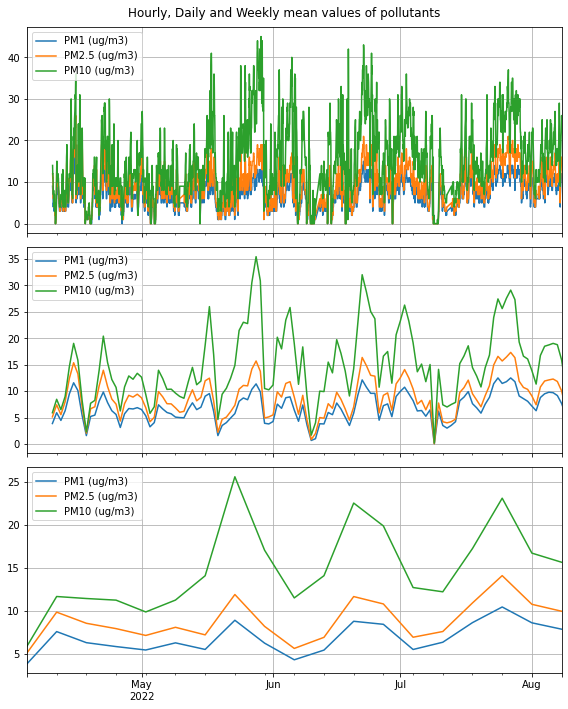

In [3]:
fig, ax = plt.subplots(3, figsize=(8,10), sharex=True)
pollutants.plot(ax=ax[0],grid=True, xlabel='')
pollutants.resample('D').mean().plot(ax=ax[1],grid=True, xlabel='')
pollutants.resample('W').mean().plot(ax=ax[2],grid=True, xlabel='')

plt.suptitle('Hourly, Daily and Weekly mean values of pollutants')
plt.tight_layout()
plt.savefig("Plots/Resampling/resampling.png")
plt.show()

In [4]:
pollutants_24 = pollutants.groupby(df.index.hour).mean()
pollutants_week = pollutants.groupby(df.index.dayofweek).mean()

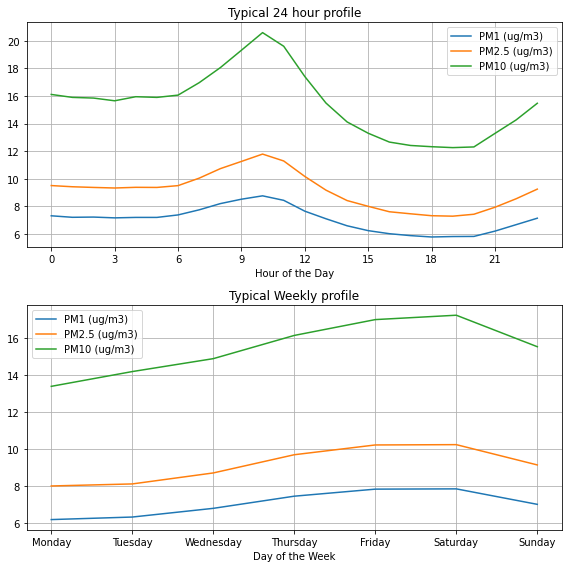

In [5]:
fig, ax = plt.subplots(2, figsize=(8,8))

pollutants_24.plot(xlabel='Hour of the Day', grid=True, ax=ax[0])
pollutants_week.plot(xlabel='Day of the Week', grid=True, ax=ax[1]).legend(loc=2)

ax[0].set_title('Typical 24 hour profile')
ax[0].set_xticks(np.arange(0,24,3))

ax[1].set_title('Typical Weekly profile')
ax[1].set_xticks(range(7))
ax[1].set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

plt.tight_layout()
plt.savefig("Plots/Typical/.typical.png")
plt.show()

### Correlation

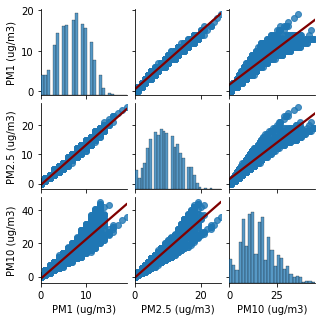

In [6]:
sns.pairplot(data=df, kind='reg', plot_kws={'line_kws': {'color': 'maroon'}},height=1.5)
plt.savefig("Plots/Correlation/pairplot.png")
plt.show()

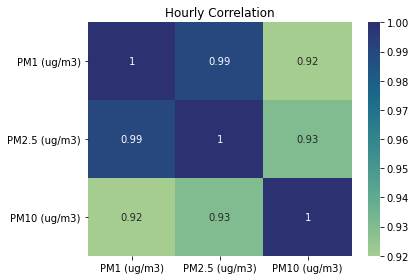

In [8]:
plt.figure()
heatmap = sns.heatmap(df.corr().round(2), annot=True, cmap='crest')
plt.title('Hourly Correlation')
plt.tight_layout()
plt.savefig("Plots/Correlation/hour_corr.png")
plt.show()

### Statistical Description

In [9]:
descriptive = pd.concat([df.describe(), df.agg(['kurtosis', 'skew'])]).round(2)
descriptive.to_csv('Plots/Descriptive/Descriptive.csv')
descriptive

,PM1 (ug/m3),PM2.5 (ug/m3),PM10 (ug/m3)
count,2926.00,2926.00,2926.00
mean,7.05,9.15,15.46
std,3.33,4.57,8.57
min,0.00,0.00,0.00
25%,5.00,6.00,9.00
50%,7.00,9.00,14.00
75%,10.00,12.00,21.00
max,19.00,26.00,45.00
kurtosis,-0.54,-0.45,-0.03
skew,-0.05,0.18,0.55


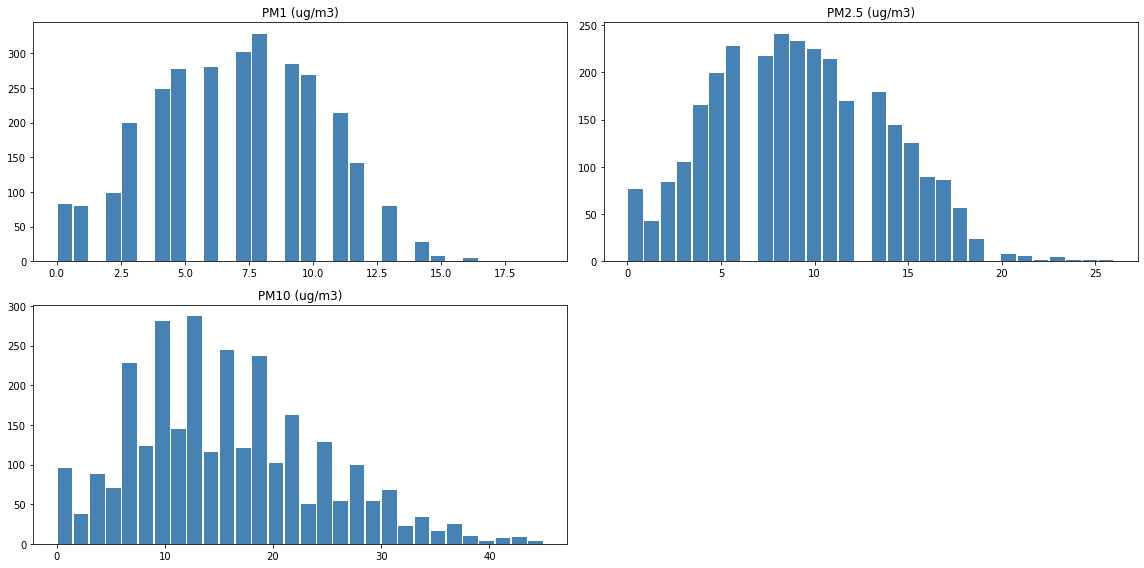

In [10]:
df.hist(bins=30, figsize=(16,8), grid=False, rwidth=0.9, color='steelblue')
plt.tight_layout()
plt.savefig("Plots/Descriptive/histograms.png")
plt.show()

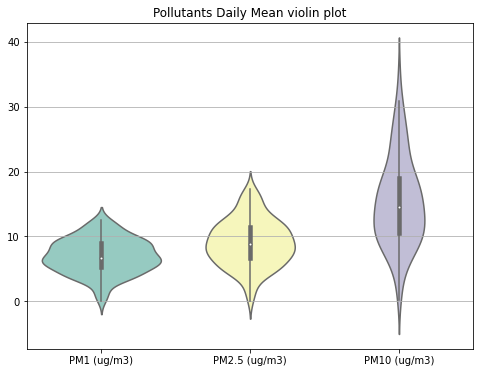

In [11]:
fig= plt.subplots(figsize=(8,6))
sns.violinplot(data=pollutants.resample('D').mean(), whis=3, palette='Set3')

plt.grid(axis='y')
plt.title('Pollutants Daily Mean violin plot')
plt.savefig("Plots/Descriptive/violin.png")
plt.show()

A combination of boxplot and kernel density estimate.

A violin plot plays a similar role as a box and whisker plot. It shows the
distribution of quantitative data across several levels of one (or more)
categorical variables such that those distributions can be compared. Unlike
a box plot, in which all of the plot components correspond to actual
datapoints, the violin plot features a kernel density estimation of the
underlying distribution. (Να εξηγήσω την αξία τους)

### Decomposition

In [12]:
daily = df.resample('D').mean()

In [13]:
pm1 = seasonal_decompose(daily['PM1 (ug/m3)'])
pm25 = seasonal_decompose(daily['PM2.5 (ug/m3)'])
pm10 = seasonal_decompose(daily['PM10 (ug/m3)'])

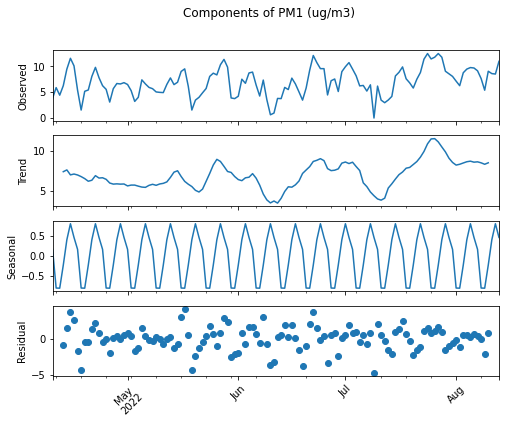

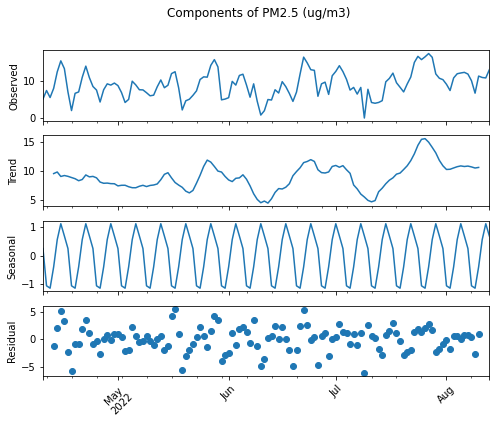

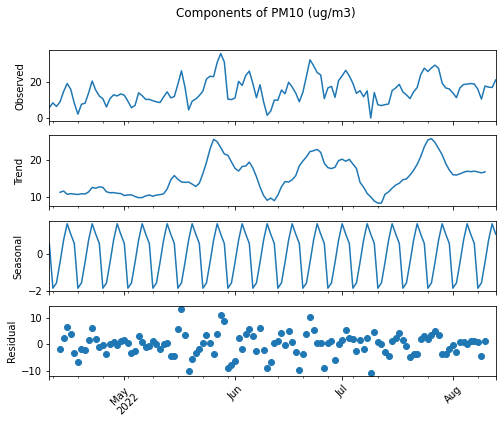

In [14]:
pollutants_list = [pm1, pm25, pm10]
for p in pollutants_list:
    fig,ax = plt.subplots(4, figsize=(8,6), sharex=True)
    p.observed.plot(rot=45, ax=ax[0])
    ax[0].set_ylabel('Observed')
    p.trend.plot(rot=45, ax=ax[1])
    ax[1].set_ylabel('Trend')
    p.seasonal.plot(rot=45, ax=ax[2])
    ax[2].set_ylabel('Seasonal')
    p.resid.plot(linestyle=' ', marker='o', rot=45, ax=ax[3])
    ax[3].set_ylabel('Residual')
    
    plt.xlabel("")
    plt.suptitle(f"Components of {p.observed.name}")
    figname = 'Plots/Decomposition/' + p.observed.name[:4] + '.png'
    plt.savefig(figname)

#### Περιοδικότητα

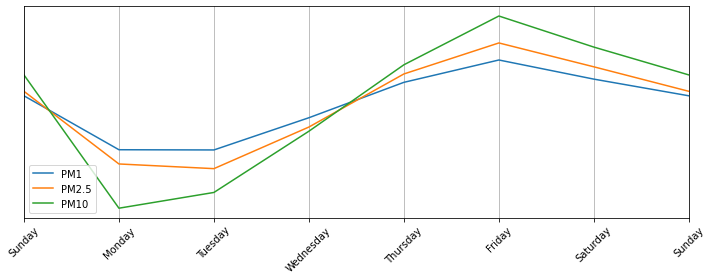

In [15]:
days = 8
plt.figure(figsize=(10,4))

pm1.seasonal[:days].plot(grid=True, label='PM1')
pm25.seasonal[:days].plot(grid=True, label='PM2.5')
pm10.seasonal[:days].plot(grid=True, label='PM10')

plt.xticks(daily.index[:days], daily.index.day_name()[:days], rotation=45)
plt.legend(loc='lower left')
plt.xlabel('')
plt.yticks([])
plt.tight_layout()
plt.savefig('Plots/Decomposition/periodicity.png')
plt.show()

Σύγκριση PMx με ΝΟ2 κατά περιοδικότητα

### Wind effect

In [16]:
airly_wind = pd.read_csv('airly_wind.csv')
direction_order = ["N","NE","E","SE","S","SW","W","NW","CALM"]

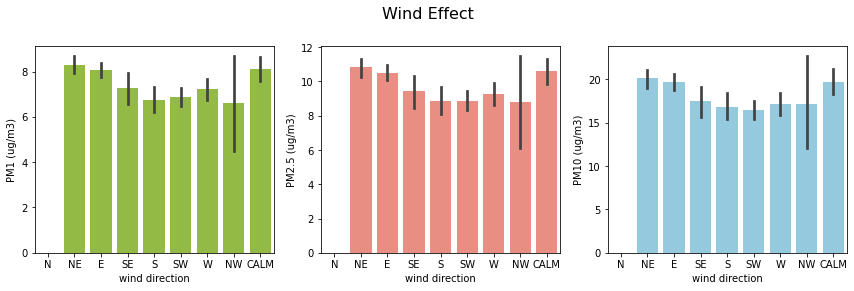

In [28]:
fig, axes = plt.subplots(1,3,figsize=(12,4))
sns.barplot(x='wind direction',y= 'PM1 (ug/m3)', data=airly_wind, order=direction_order, color='yellowgreen', ax=axes[0])
sns.barplot(x='wind direction',y= 'PM2.5 (ug/m3)', data=airly_wind, order=direction_order, color="salmon", ax=axes[1])
sns.barplot(x='wind direction',y= 'PM10 (ug/m3)', data=airly_wind, order=direction_order, color="skyblue", ax=axes[2])

fig.suptitle("Wind Effect", y=1, fontsize=16)
fig.tight_layout()
fig.savefig('Plots/Wind/barplots.png', bbox_inches='tight')
plt.show()

### Windspeed > 0.5 m/s

In [18]:
calmless = airly_wind[airly_wind.loc[:,'windspeed']>0.5]

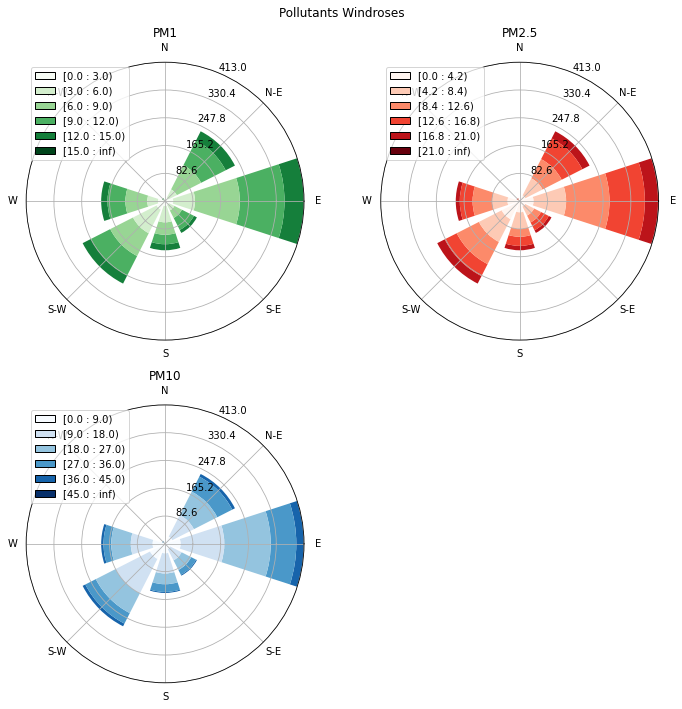

In [19]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(2,2,1, projection="windrose")
ax.bar(calmless['direction'], calmless['PM1 (ug/m3)'], nsector=8, bins=6, cmap=cm.Greens)
ax.set_title('PM1')
ax.legend(loc=2)

ax = fig.add_subplot(2,2,2, projection="windrose")
ax.bar(calmless['direction'], calmless['PM2.5 (ug/m3)'], nsector=8, bins=6, cmap=cm.Reds)
ax.set_title('PM2.5')
ax.legend(loc=2)

ax = fig.add_subplot(2,2,3, projection="windrose")
ax.bar(calmless['direction'], calmless['PM10 (ug/m3)'], nsector=8, bins=6, cmap=cm.Blues)
ax.set_title('PM10')
ax.legend(loc=2)

plt.suptitle("Pollutants Windroses")
plt.tight_layout()
plt.savefig("Plots/Wind/windrose.png")
plt.show()

Bins κατά WHO για κάθε ρύπο.